In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(r"../input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
deltas = [0.10, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7]
min_delta = 0.50
# ot Option Type can be C or P (case-sensitive)
ot = 'C'
same_day = False
purchase_time = '15:45:00'

commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

In [2]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike, option_type):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['strike']==strike) & (df['type']==option_type) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    if option_type == 'P':
        diff = strike - underlying
    else:
        diff = underlying - strike
    if diff > 0.0:
        return diff*100
    return 0      

In [3]:
all_trade_dfs = []
all_plot_dfs = []
for min_delta in deltas:
    df_trades = pd.DataFrame(df['expiration'].unique())
    df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
    df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
    df_trades = df_trades[df_trades['trade_date'].isnull()==False]
    df_trades['collected'] = 0.0
    df_trades['lost'] = 0.0
    df_trades['strike'] = 0
    df_trades['delta'] = 0.0
    df_trades['net'] = 0.0
    df_trades['commission'] = commission

    # Create new filtered dataframe with only calls above target delta
    df_calls = df[(df['type']=="C") & (df['delta']>= min_delta) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_calls = df_calls.loc[df_calls.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_calls = df_calls.loc[df_calls.groupby('quote_date')[['dte']].idxmin()['dte']]

    # Create new filtered dataframe with only puts above target delta
    df['delta'] = df['delta'].abs()
    df_puts = df[(df['type']=="P") & (df['delta']>= min_delta) & (df['quote_time'] == purchase_time) & (df['dte'] > dte_f)]
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_puts = df_puts.loc[df_puts.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_puts = df_puts.loc[df_puts.groupby('quote_date')[['dte']].idxmin()['dte']]

    #Need to figure out how to extract strike, delta, and the average between bid/ask from one "apply" operation
    df_trades['strike'],df_trades['delta'],df_trades['collected'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_calls if ot == 'C' else df_puts), axis = 1).T.values
    df_trades['lost'] = df_trades.apply(lambda row : get_amount_lost(row['expiration'], row['strike'], ot), axis=1)
    df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
    
    # if you want to scale the chart, you should do it here
    factor = 1.0
    df_trade_plot = df_trades.copy()
    df_trade_plot['net'] = df_trade_plot['net']*factor
    df_trade_plot.set_index('expiration', inplace=True)
    df_trade_plot = df_trade_plot['net'].cumsum()
    
    all_trade_dfs.append(df_trades)
    all_plot_dfs.append(df_trade_plot)

In [4]:
df_trades.tail(40)

,expiration,trade_date,collected,lost,strike,delta,net,commission
121,2021-10-08,2021-10-06,5480.0,8096.0,4310.0,0.7154,-2617.5,1.5
122,2021-10-11,2021-10-08,3245.0,0.0,4370.0,0.7033,3243.5,1.5
123,2021-10-13,2021-10-11,4780.0,2898.0,4335.0,0.7041,1880.5,1.5
124,2021-10-15,2021-10-13,4445.0,14601.0,4325.0,0.7087,-10157.5,1.5
125,2021-10-18,2021-10-15,2665.0,3657.0,4450.0,0.7185,-993.5,1.5
126,2021-10-20,2021-10-18,3075.0,7661.0,4460.0,0.7065,-4587.5,1.5
127,2021-10-22,2021-10-20,2910.0,3508.0,4510.0,0.7200,-599.5,1.5
128,2021-10-25,2021-10-22,2455.0,4209.0,4525.0,0.7429,-1755.5,1.5
129,2021-10-27,2021-10-25,2785.0,695.0,4545.0,0.7294,2088.5,1.5
130,2021-10-29,2021-10-27,3215.0,6475.0,4540.0,0.7117,-3261.5,1.5


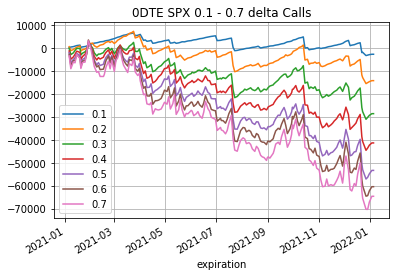

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for df_plot in all_plot_dfs:
    df_plot.plot(ax=ax)
ax.legend(deltas)
plt.title(f"0DTE SPX {deltas[0]} - {deltas[-1]} delta {'Calls' if ot=='C' else 'Puts'}")
plt.grid()
plt.savefig(f"{min_delta}.png")